<a href="https://colab.research.google.com/github/Kaaviya-E/Adaptive-HARQ-Scheduling-for-5G-IoT-in-Non-Terrestrial-Networks/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

Loading dataset and model...
Dataset shape: (3840, 21)
Loaded delay model: rf_dd2a_ug2d_model.pkl
Sim finished in wall time: 43.71127414703369 s
Total packets: 200, Succeeded: 200, Success rate: 1.000, Avg attempts: 1.045
Saved harq_sim_results.csv
Saved harq_attempts_hist.png


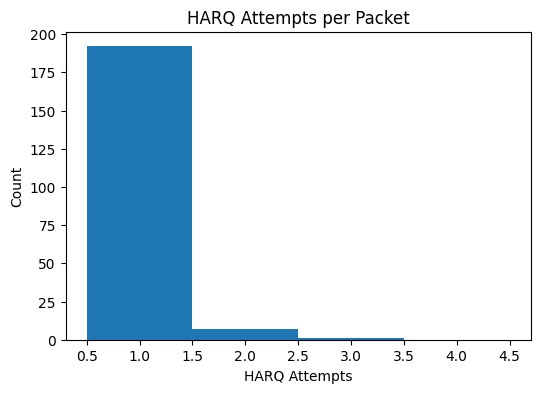

In [ ]:
# harq_sim_with_predictor.py
import simpy
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------ USER CONFIG -------------
CSV = "ntn_harq_dataset.csv"
DELAY_MODEL_PATH = "rf_dd2a_ug2d_model.pkl"  # trained predictor (from Step 1)
NUM_PACKETS = 200                            # how many packets to simulate
PACKET_INTERVAL_MS = 10                      # time between packet transmissions from BS (ms)
MAX_RETX = 3                                 # max HARQ retransmissions (not infinite)
HARQ_TIMEOUT_MS = 200                        # HARQ timeout guard (ms) - will be compared to predicted ack arrival
PROPAGATION_DELAY_MS = 10                    # fixed propagation one-way (ms) if RTT not available
USE_RTT_IF_PRESENT = True                    # if dataset has RTT_ms use it
ASSUME_PRED_IN_MS = True                     # if model predicts in ms. If predictions in subframes, adjust conversion
PACKET_LOSS_PROB = 0.05                      # physical packet loss probability at UE per transmission
RANDOM_SEED = 42
# ---------------------------------------

np.random.seed(RANDOM_SEED)

# -------- Helper: prepare a per-packet feature row for predictor ----------
def make_feature_row(base_df_mean, base_df_mode, tbphc=None, reps=None):
    """
    Build a 1-row DataFrame with required features for the predictor.
    We use mean for numeric columns and mode for categorical, with optional overrides.
    Add or override columns as needed by your model's expected inputs.
    """
    row = base_df_mean.copy()   # pandas Series
    # fill categorical features with mode values from dataset
    for c in base_df_mode.index:
        if c not in row.index:
            row.loc[c] = base_df_mode[c]
    # allow small randomization to simulate dynamics
    # example: jitter RTT or SNR a bit
    if "RTT_ms" in row.index:
        row["RTT_ms"] = max(1.0, row["RTT_ms"] * (1 + np.random.normal(0, 0.05)))
    if "SNR_dB" in row.index:
        row["SNR_dB"] = row["SNR_dB"] + np.random.normal(0, 1.0)
    if tbphc is not None:
        row["N_TBPHC"] = tbphc
    if reps is not None:
        row["n_repetitions"] = reps
    # ensure proper dtypes
    return pd.DataFrame([row])

# ---------- Load model and dataset ----------
print("Loading dataset and model...")
df = pd.read_csv(CSV)
print("Dataset shape:", df.shape)
# compute numeric mean and categorical mode for default inputs
numeric_means = df.select_dtypes(include=[np.number]).mean()
modes = df.mode().iloc[0] if not df.mode().empty else pd.Series(dtype=object)

# load predictor (pipeline)
delay_model = joblib.load(DELAY_MODEL_PATH)
print("Loaded delay model:", DELAY_MODEL_PATH)

# helper to predict safely (handles 1D and 2D outputs)
def predict_dd2a_ug2d(model, X_row):
    pred = model.predict(X_row)  # may be array shape (1,2) or (2,) or list
    arr = np.asarray(pred)
    if arr.ndim == 1:
        # could be length-2 vector
        if arr.size == 2:
            return float(arr[0]), float(arr[1])
        else:
            raise ValueError("Predictor returned 1D output with unexpected length: " + str(arr.shape))
    elif arr.ndim == 2:
        if arr.shape[1] >= 2:
            return float(arr[0,0]), float(arr[0,1])
        else:
            raise ValueError("Predictor returned 2D output with <2 columns: " + str(arr.shape))
    else:
        raise ValueError("Unexpected prediction shape: " + str(arr.shape))

# ---------- SimPy processes ----------
class HARQSim:
    def __init__(self, env, delay_model, df_mean, df_mode):
        self.env = env
        self.delay_model = delay_model
        self.df_mean = df_mean
        self.df_mode = df_mode
        self.stats = defaultdict(list)
        self.packet_count = 0

    def bs_send_packets(self, num_packets, interval_ms):
        """BS process that sends packets at regular intervals"""
        for i in range(num_packets):
            self.packet_count += 1
            pkt_id = self.packet_count
            self.env.process(self.handle_packet(pkt_id))
            yield self.env.timeout(interval_ms/1000.0)  # convert ms -> s

    def handle_packet(self, pkt_id):
        """Simulate the full HARQ exchange for a single packet"""
        send_time = self.env.now  # seconds
        attempts = 0
        success = False
        while attempts <= MAX_RETX and not success:
            attempts += 1
            # log send
            # simulate propagation: bs -> ue (one-way)
            # Use RTT_ms from mean if available, else PROPAGATION_DELAY_MS
            if USE_RTT_IF_PRESENT and "RTT_ms" in self.df_mean.index:
                prop_ms = float(self.df_mean["RTT_ms"])/2.0
            else:
                prop_ms = PROPAGATION_DELAY_MS
            # time for UE to receive the packet
            ue_receive_delay_s = prop_ms/1000.0
            yield self.env.timeout(ue_receive_delay_s)

            # physical packet loss: maybe UE didn't decode -> no ACK
            phys_loss = np.random.rand() < PACKET_LOSS_PROB
            if phys_loss:
                # UE fails to decode and won't send ACK (or sends NACK, but we treat as no ACK)
                # schedule nothing and let BS wait for HARQ timeout
                ack_expected = False
                predicted_total_delay_s = None
            else:
                # build feature row for prediction (you can customize which columns)
                # Optionally vary tbphc and reps across attempts
                feats = make_feature_row(self.df_mean, self.df_mode)
                # call predictor
                try:
                    n_dd2a, n_ug2d = predict_dd2a_ug2d(self.delay_model, feats)
                except Exception as e:
                    print("Prediction error at time", self.env.now, "err:", e)
                    n_dd2a, n_ug2d = float(self.df_mean.get("n_DD2A", 10)), float(self.df_mean.get("n_UG2D", 10))
                # ensure non-negative
                n_dd2a = max(0.0, n_dd2a)
                n_ug2d = max(0.0, n_ug2d)
                # total round-trip additional processing delay at UE+uplink (ms)
                # depending on your model, DD2A could be downlink decode delay and UG2D uplink delay
                # A simple mapping: ACK_arrival_time = now + n_DD2A + n_UG2D + prop_back
                # we already advanced time to when UE received packet
                # add UE internal processing (n_ug2d) and UL propagation (prop_ms) and any additional n_dd2a if needed
                # Here we compute ACK arrival from current env.now:
                # convert ms->s
                predicted_total_delay_s = (n_dd2a + n_ug2d + prop_ms)/1000.0
                ack_expected = True

            # BS waits for ACK or timeout (HARQ timer)
            # We simulate waiting: either ACK event occurs after predicted_total_delay_s or not
            if ack_expected and predicted_total_delay_s is not None:
                # yield a timeout representing ACK arrival
                # but if predicted_total_delay_s > HARQ timeout, BS will timeout first -> retransmit
                # use min to decide ordering
                if predicted_total_delay_s <= HARQ_TIMEOUT_MS/1000.0:
                    # ACK arrives in time
                    yield self.env.timeout(predicted_total_delay_s)
                    success = True
                    self.stats["packet"].append(pkt_id)
                    self.stats["attempts"].append(attempts)
                    self.stats["success_time_s"].append(self.env.now - send_time)
                    break
                else:
                    # predicted ACK arrival after HARQ timeout -> BS will retransmit at timeout
                    yield self.env.timeout(HARQ_TIMEOUT_MS/1000.0)
                    # loop continues for retransmission
            else:
                # no ack_expected (physical loss) -> wait for HARQ timeout then retransmit
                yield self.env.timeout(HARQ_TIMEOUT_MS/1000.0)
                # continue loop -> retransmit if attempts left

        # after loop
        if not success:
            self.stats["packet"].append(pkt_id)
            self.stats["attempts"].append(attempts)
            self.stats["success_time_s"].append(None)  # failed

# ---------- Run simulation ----------
env = simpy.Environment()
sim = HARQSim(env, delay_model, numeric_means, modes)
env.process(sim.bs_send_packets(NUM_PACKETS, PACKET_INTERVAL_MS))
start_wall = time.time()
env.run()   # run until no events
print("Sim finished in wall time:", time.time() - start_wall, "s")

# ---------- Report ----------
results_df = pd.DataFrame({
    "packet": sim.stats["packet"],
    "attempts": sim.stats["attempts"],
    "success_time_s": sim.stats["success_time_s"]
})
total = len(results_df)
succeeded = results_df["success_time_s"].notna().sum()
avg_attempts = results_df["attempts"].mean()
print(f"Total packets: {total}, Succeeded: {succeeded}, Success rate: {succeeded/total:.3f}, Avg attempts: {avg_attempts:.3f}")

# Save CSV and simple plot
results_df.to_csv("harq_sim_results.csv", index=False)
print("Saved harq_sim_results.csv")

# histogram of attempts
plt.figure(figsize=(6,4))
plt.hist(results_df["attempts"].dropna(), bins=np.arange(1, MAX_RETX+3)-0.5)
plt.xlabel("HARQ Attempts")
plt.ylabel("Count")
plt.title("HARQ Attempts per Packet")
plt.savefig("harq_attempts_hist.png")
print("Saved harq_attempts_hist.png")
